In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import mnnpy

import gseapy as gp

In [26]:
#functions

def run_GSEA(dic):
    sig_ranked_dataframe = pd.DataFrame()
    sig_ranked_dataframe[0] = dic.keys()
    sig_ranked_dataframe[1] = list(dic.values())

    gene_set = 'GO_Biological_Process_2018'

    res = gp.prerank(rnk=sig_ranked_dataframe,
                                         gene_sets=gene_set,
                                         max_size = 1000,
                                         min_size = 5, #number of overlapping genes, I think
                                         processes= 32,
                                         permutation_num=1000, # reduce number to speed up test
                                         no_plot = True,
                                         outdir='gsea_plots/prerank_report_'+gene_set,format='png')
    return res

# Load Data

Loading and labeling the data. Future analyses can begin from #Analysis.

In [30]:
df = pd.read_csv("Samples17_3A_16_2A_16_B.txt", sep="\t")

In [36]:
df.index = [x.split("_")[1] for x in df["geneID"].values] #use geneIDs instead of Ensembl IDs
df = df.drop("geneID", axis=1)
print (df.shape)
df.head()

(49466, 864)


,25-35_A4,25-35_A5,25-35_A6,25-35_B4,25-35_B5,25-35_B6,25-35_C4,25-35_C5,25-35_C6,25-35_D4,...,BFUE-D3_95,DEX-D1_95,DEX-D2_95,DEX-D3_95,BFUE-D1_96,BFUE-D2_96,BFUE-D3_96,DEX-D1_96,DEX-D2_96,DEX-D3_96
mt-Tp,7,10,7,10,3,17,13,4,2,7,...,8,8,17,0,2,0,1,6,8,4
mt-Tt,0,0,0,1,0,5,0,0,0,2,...,6,6,14,1,0,0,0,5,0,3
mt-Cytb,4033,4422,3427,4494,3884,4951,5133,2371,3474,3605,...,5408,4820,3411,4561,3215,297,2282,5260,4186,4689
mt-Te,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
mt-Nd6,49,42,64,82,71,74,75,48,67,53,...,174,108,195,105,79,28,73,38,125,96


In [39]:
adata = sc.AnnData(df.T)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [40]:
adata

AnnData object with n_obs × n_vars = 864 × 49466 

### Label Samples

In [41]:
#label cell types
adata.obs["batch"] = [x.split("_")[0] for x in adata.obs_names]
np.unique(adata.obs["batch"])

array(['25-35', '50-60', 'BFUE', 'BFUE-D1', 'BFUE-D2', 'BFUE-D3', 'CFUE',
       'DEX-D1', 'DEX-D2', 'DEX-D3'], dtype=object)

In [43]:
#save file
adata.write("cells_by_geneID.h5ad")

# Preprocessing

In [3]:
adata = sc.read_h5ad("cells_by_geneID.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


I'm seeing a lot of mitochondrial genes in the first two principle components. Let's filter some genes out and run PCA again...

In [4]:
adata.var_names_make_unique()

In [5]:
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=5)
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

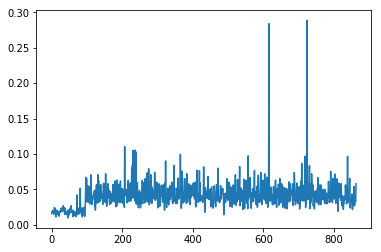

In [6]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
plt.plot(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))

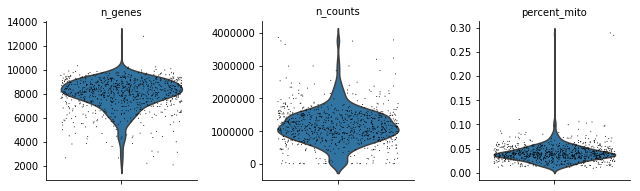

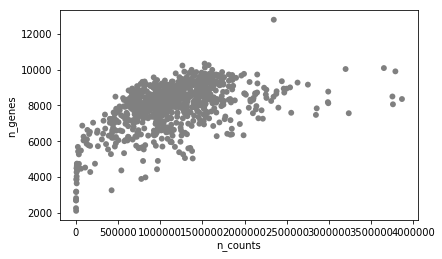

In [7]:
sc.pl.violin(adata, ['n_genes','n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [8]:
#let's remove some of the cells with reaaaallly high mt expression...
adata = adata[adata.obs['percent_mito'] < .07]
adata

View of AnnData object with n_obs × n_vars = 825 × 23466 
    obs: 'batch', 'n_genes', 'n_counts', 'percent_mito'
    var: 'n_cells'

In [9]:
#lock adata.raw
adata.raw = sc.pp.log1p(adata, copy=True)

In [10]:
#seurat
# sc.pp.recipe_seurat(adata)

#seurat as in scanpy, but setting n_top_genes at 3k
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=3000, log=False)
adata._inplace_subset_var(filter_result.gene_subset)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

#cell ranger
# sc.pp.recipe_zheng17(adata, n_top_genes=3000)


adata

AnnData object with n_obs × n_vars = 825 × 3000 
    obs: 'batch', 'n_genes', 'n_counts', 'percent_mito'
    var: 'n_cells'

Now let's run PCA again...

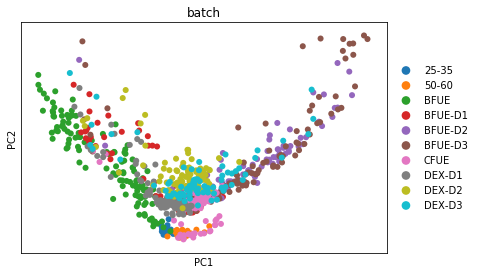

In [11]:
sc.tl.pca(adata) #default is n_comp = 50
sc.pl.pca(adata, color="batch")

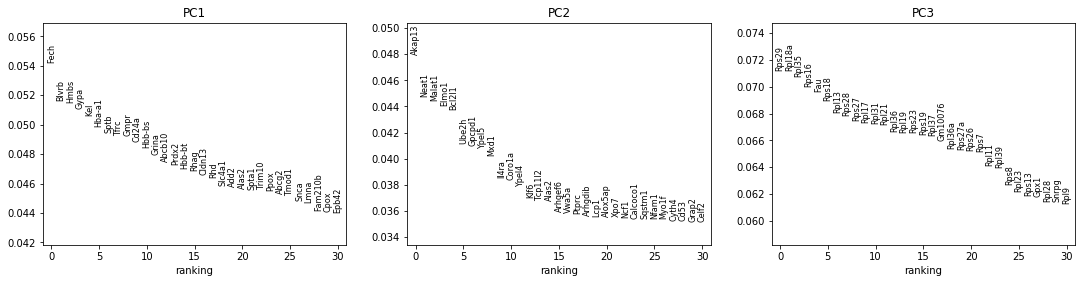

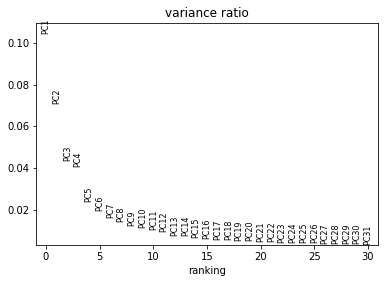

In [12]:
sc.pl.pca_loadings(adata)
sc.pl.pca_variance_ratio(adata)

Tbh, these principle components look much more reasonable.

In [116]:
#save because this preprocessing looks alright
adata.write("seurat_processed.h5ad")

In [53]:
#an alternate pre-processing method on just the batch correction cells
# adata.write("seurat_processed_10kgenes.h5ad")

In [33]:
adata = sc.read_h5ad("cells_by_geneID.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [34]:
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 864 × 49466 
    obs: 'batch'

## Run GSEA on the PCA loadings

In [36]:
#find list of PCA genes (no function that returns it in Scanpy)

num_genes = 200
pcs = 7
loadings = {}

for i in range(pcs):
    values = []
    gene_list = list(adata.var_names)
    for j in range(len(adata.var_names)): #for all the genes
        values.append(adata.varm["PCs"][j][i])
    
    values, genes = zip(*sorted(zip(values, gene_list), reverse=True))
    
    loadings[i] = dict(zip([x.upper() for x in genes[:num_genes]], values[:num_genes]))

In [39]:
res = run_GSEA(loadings[1])

In [40]:
res.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes
Term,,,,,,,
negative regulation of cellular macromolecule biosynthetic process (GO:2000113),-0.515464,-1.566290,0.055944,0.530627,513,6,"BTG2,CDKN1B,HDAC5,LIMS1,RUNX2,FOXP1"
regulation of GTPase activity (GO:0043087),-0.451282,-1.253147,0.190361,0.625754,189,5,"FGD2,ARHGAP27,DOCK10,LIMS1,ABR"
regulation of protein kinase activity (GO:0045859),-0.456327,-1.270334,0.188811,0.640786,148,5,"PTPRC,RASSF2,GNAQ,CISH,LCP2"
negative regulation of nucleic acid-templated transcription (GO:1903507),-0.558974,-1.585505,0.041002,0.645448,445,5,"CDKN1B,HDAC5,LIMS1,RUNX2,FOXP1"
receptor-mediated endocytosis (GO:0006898),-0.386598,-1.220779,0.225888,0.648364,189,6,"FCER1G,ARHGAP27,ADRB2,SYK,RAB31,CD9"
regulation of cell migration (GO:0030334),-0.487226,-1.351865,0.138425,0.650186,317,5,"ADGRG3,CSF1R,ADAM15,DOCK10,ARHGAP4"
positive regulation of protein phosphorylation (GO:0001934),-0.355984,-1.306500,0.167526,0.687561,413,9,"PTPRC,FLT3,ADRB2,RASSF2,CSF1R,CCND1,HCLS1,CD27..."
positive regulation of intracellular signal transduction (GO:1902533),-0.224738,-0.989813,0.449239,0.696237,480,12,"AKAP13,BCL2L1,NCF1,FLT3,ADRB2,CSF1R,REL,HCLS1,..."
antigen receptor-mediated signaling pathway (GO:0050851),-0.387346,-1.272792,0.191388,0.699514,258,7,"PTPRC,GRAP2,PSMB8,SYK,PLCG2,PIK3R1,LCP2"


In [ ]:
#save genes to a text file and submit to DAVID
with open('gene_lists/pc1_loadings.txt', 'w') as f:
    for probe in list(degs_dict.keys()):
        f.write("%s\n" % probe)

## Remove mitochondrial genes (increases the # of genes???)

In [39]:
non_mito

['Cdk4',
 'Txndc8',
 'Slco1b2',
 'Padi6',
 'Pxylp1',
 'AC145736.2',
 'Pacsin1',
 'AC145736.1',
 'Dgka',
 'Uba5',
 'Rapgef6',
 'Gm20444',
 'Atp11a',
 'Gm13884',
 'Cyp4a31',
 '2010310C07Rik',
 'Nr6a1',
 'Brat1',
 'Gm8906',
 'Gm44284',
 'Gm11789',
 'Gm43929',
 'Zyx',
 'Gm42830',
 'Fam216a',
 'Trav7-1',
 'Magel2',
 'Fam46d',
 'Mxd4',
 'Mkrn3',
 'Gm12258',
 'Gm3788',
 'Gm32061',
 'Mab21l2',
 'Ndn',
 'Cdk2',
 'Gm37876',
 'Bicdl1',
 'Olfr591',
 'Ighv1-45',
 'Scn5a',
 'Gm43930',
 'Gm37750',
 'Gm21040',
 'Platr14',
 'Gm38228',
 'Acad11',
 '2610002M06Rik',
 '4930599A14Rik',
 'Nck2',
 'Vps29',
 'Coa7',
 'Gm42846',
 'Gm7985',
 'Gm43655',
 'Daam1',
 'AC107635.1',
 'CT009748.1',
 'Gm43737',
 'Gm5609',
 'CT009748.2',
 'Pwp1',
 'Mtx1',
 '1700028D13Rik',
 'AU021092',
 '1810034E14Rik',
 'Gm37536',
 'Rbms2',
 'Gm14143',
 'Pcdh12',
 'Msr1',
 'Gtf2ird2',
 'Aaed1',
 'Alg5',
 'CT030124.1',
 'Gm16131',
 'Tmbim4',
 'Tmpo',
 'Olfr877',
 'Gm16130',
 'Gm44144',
 '4930453N24Rik',
 'Gm44146',
 '5730507A11Rik',
 'Mi

In [49]:
non_mito = [x for x in adata.var_names if x[:2] != "mt"]
len(non_mito)

49429

In [48]:
adata = adata[:, non_mito]

49585

View of AnnData object with n_obs × n_vars = 864 × 49585 
    obs: 'batch'

# Analysis

## BFUE -> CFUE Control Replicates

In [45]:
# adata = sc.read_h5ad("cells_by_geneID.h5ad")
# adata = sc.read_h5ad("seurat_processed.h5ad")
adata = sc.read_h5ad("seurat_processed_10kgenes.h5ad")

In [46]:
control_cells = adata[adata.obs["batch"].isin(["BFUE", "CFUE", "25-35", "50-60"])]

In [47]:
#there are two replicates
control_cells.obs["replicate"] = ["Broad" if len(x.split("_")) > 2 else "local" for x in control_cells.obs_names]

In [194]:
#don't run this if you're about to use control_cells
filter_result = sc.pp.filter_genes_dispersion(control_cells.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000, log=False)
control_cells._inplace_subset_var(filter_result.gene_subset)

... storing 'replicate' as categorical


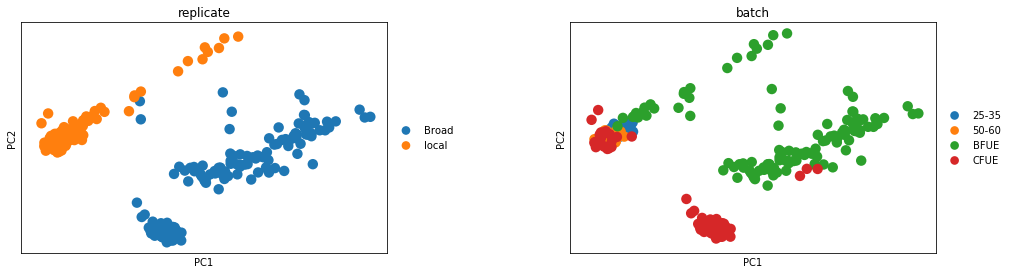

In [48]:
sc.tl.pca(control_cells)
sc.pl.pca(control_cells, color=["replicate", "batch"]) #1 = replicates not from the CD17/24 batch

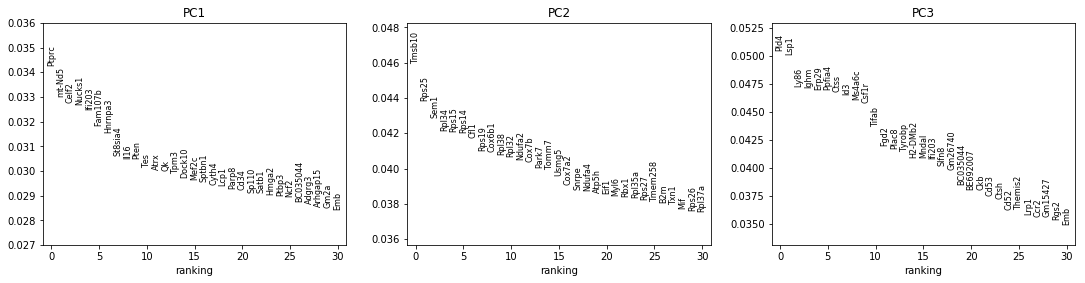

In [200]:
sc.pl.pca_loadings(control_cells)

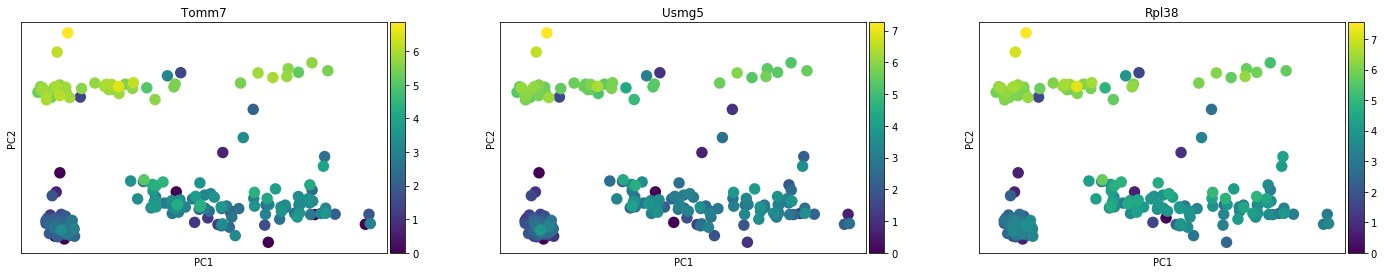

In [15]:
sc.pl.pca(control_cells, color=["Tomm7", "Usmg5", "Rpl38"])

We see that the pattern here is mostly a result of batch effect. Unfortunately, taking the gene values after running Seurat also partitions based on replicate. My only conclusion is that generating principle components using all of the data will result in an overimportance of genes that contribute mostly to technical variation.

Interesting note: one huge difference between the replicates are the % of mitochondrial genes - the Broad's Smart2Seq seems to kill the cells a heck of a lot more.

### Removing batch effect

In [49]:
#get the other cells and label them (they're all from the Broad)
other_cells = adata[adata.obs["batch"].isin(["BFUE-D1", "BFUE-D2", "BFUE-D3", "DEX-D1", "DEX-D2", "DEX-D3"])]
other_cells.obs["replicate"] = ["Broad" for x in other_cells.obs_names]

#conbine all cells into one data
replicate_data = sc.AnnData.concatenate(control_cells, other_cells) 

#relabel cell types again after concatenate because it automatically overrides "batch"
replicate_data.obs["batch"] = [x.split("_")[0] for x in bdata.obs_names]
np.unique(replicate_data.obs["batch"])

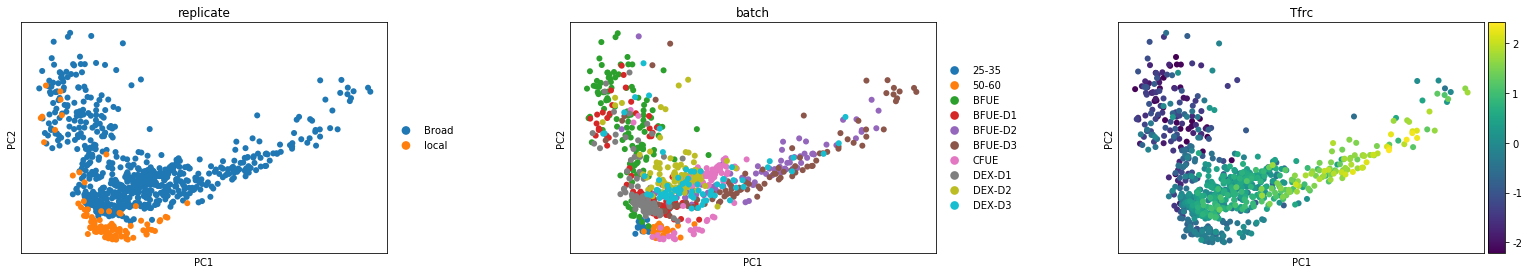

In [183]:
sc.tl.pca(replicate_data)
sc.pl.pca(replicate_data, color=['replicate', "batch", "Tfrc"])

In [119]:
r1 = replicate_data[replicate_data.obs["replicate"] == "local"]
r2 = replicate_data[replicate_data.obs["replicate"] == "Broad"]

Running mnn correct method based on this paper: https://www.nature.com/articles/nbt.4091 with "default" parameters

In [179]:
corrected = mnnpy.mnn_correct(r2, r1, batch_key="replicate", k=24, save_raw=True) #note: order of the samples matters

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [180]:
bdata = corrected[0].copy()
bdata

AnnData object with n_obs × n_vars = 825 × 10000 
    obs: 'batch', 'n_genes', 'n_counts', 'percent_mito', 'replicate'
    var: 'n_cells-0-0', 'n_cells-1-0', 'n_cells-0-1', 'n_cells-1-1'

Now that we've corrected for batch effect on the top 10k genes, let's do the rest of the analysis with only 1k genes.

In [185]:
#don't use if you're combining bdata later - filtering down to 1k genes
filter_result = sc.pp.filter_genes_dispersion(bdata.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000, log=False)
bdata._inplace_subset_var(filter_result.gene_subset)

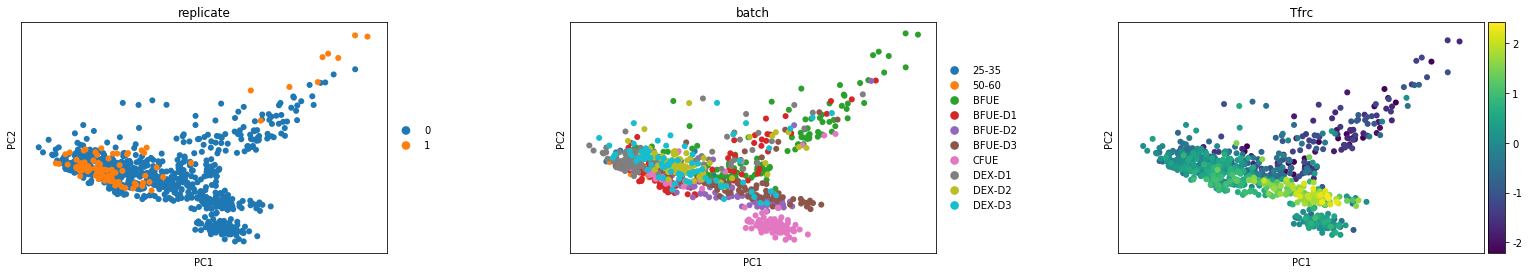

In [186]:
sc.tl.pca(bdata)
sc.pl.pca(bdata, color=['replicate', "batch", "Tfrc"])

It looks like the Broad data doesn't have the intermediate populations...? Is that reasonable? If not, my hypothesis is just that it's mixed in with the BFUEs.

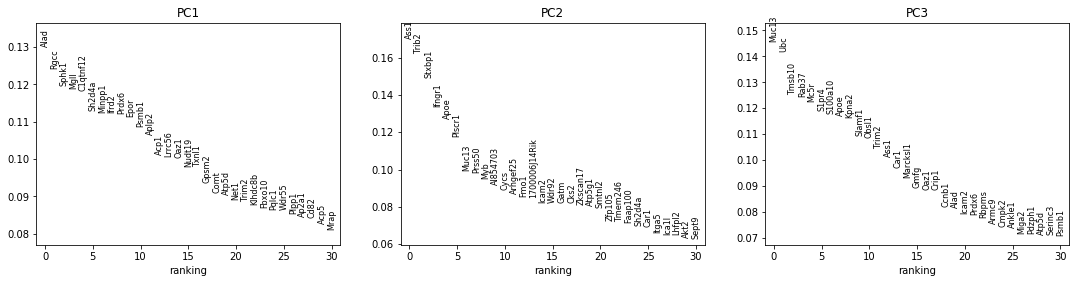

In [112]:
sc.pl.pca_loadings(bdata)

This looks alright to me... I can't think of how I would want this to be better, other than getting rid of those cells in the middle, but I'm not sure why that's occurring so...

In [162]:
sc.pp.neighbors(bdata, n_neighbors=15, n_pcs=50) #set to gauss to use the original implementation of diffmap
sc.tl.diffmap(bdata)
# sc.tl.louvain(bdata, resolution=.6)

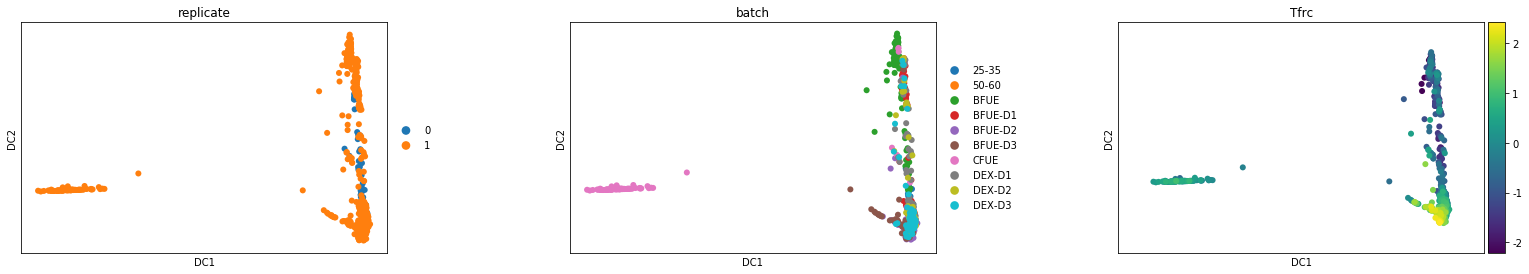

In [164]:
sc.pl.diffmap(bdata, color=['replicate', "batch", "Tfrc"])

Looks good. Now to pick these genes out of the other data...

### Mapping the rest of the dataset onto it (doesn't work with diffmap yet)

In [3]:
adata = sc.read_h5ad("cells_by_geneID.h5ad")
adata.var_names_make_unique()
remaining_cells = adata[adata.obs["batch"].isin(["BFUE-D1", "BFUE-D2", "BFUE-D3", "DEX-D1", "DEX-D2", "DEX-D3"])]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
#filter the other cells by the genes we have values for batch mixing from
remaining_cells = remaining_cells[:, bdata.var_names.values]
remaining_cells

View of AnnData object with n_obs × n_vars = 576 × 10000 
    obs: 'batch'

In [13]:
#bdata + remaining_cells
full_data = sc.AnnData.concatenate(bdata, remaining_cells, batch_key="treated")
full_data

/home/yji/.local/lib/python3.6/site-packages/anndata/base.py:1811: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


AnnData object with n_obs × n_vars = 852 × 10000 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'replicate', 'treated'
    var: 'n_cells-0-0', 'n_cells-1-0'

In [14]:
#seurat as in scanpy, but setting n_top_genes at 1k
full_data.raw = sc.pp.log1p(full_data, copy=True)

# sc.pp.normalize_per_cell(full_data, counts_per_cell_after=1e4) #already normalized, don't do again
filter_result = sc.pp.filter_genes_dispersion(full_data.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000, log=False)
full_data._inplace_subset_var(filter_result.gene_subset)
sc.pp.log1p(full_data)
# sc.pp.scale(full_data, max_value=10)

In [15]:
full_data

AnnData object with n_obs × n_vars = 852 × 1000 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'replicate', 'treated'
    var: 'n_cells-0-0', 'n_cells-1-0'

... storing 'batch' as categorical
... storing 'replicate' as categorical


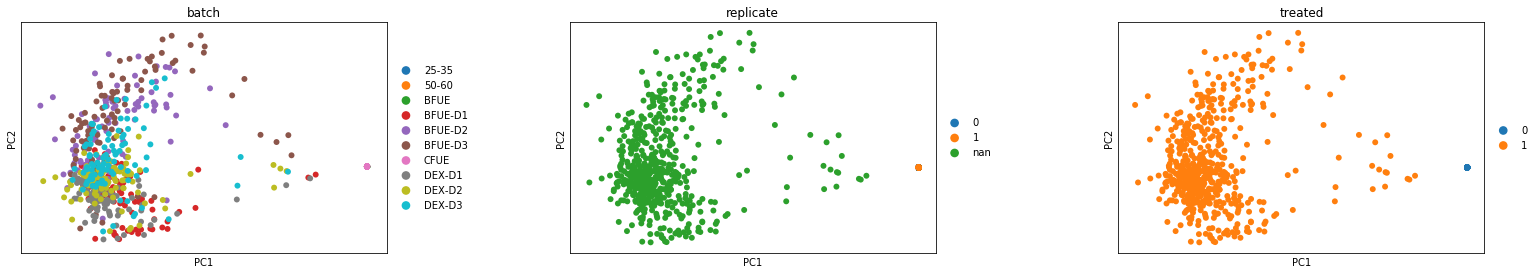

In [16]:
sc.tl.pca(full_data)
sc.pl.pca(full_data, color=["batch", "replicate", "treated"])

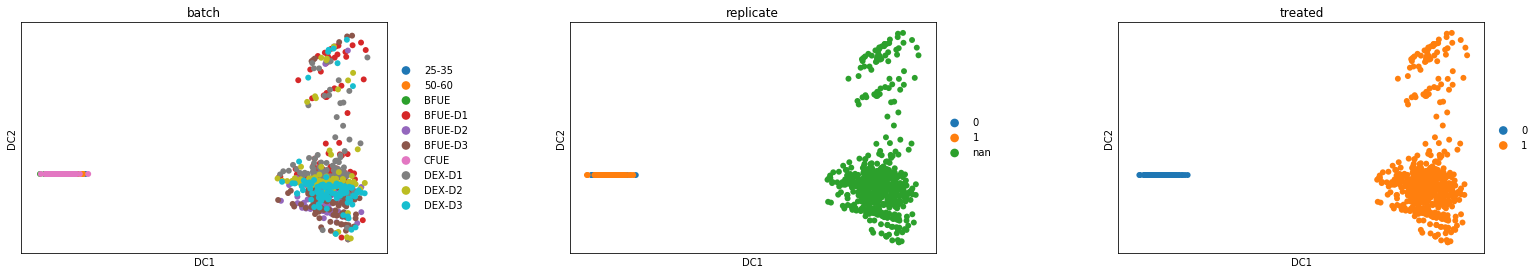

In [20]:
sc.pp.neighbors(full_data, n_neighbors=5, n_pcs=50)
sc.tl.diffmap(full_data)
sc.pl.diffmap(full_data, color=["batch", "replicate", "treated"])

Hmm... looks like adjusting for batch effect really moves the cells way out of the way, regardless of which sample we adjust onto :/

## Non-treated cells, first replicate (Hojun's Smart2Seq)

In [188]:
adata = sc.read_h5ad("cells_by_geneID.h5ad")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [189]:
#these are all the untreated cells
untreated_cells = adata[adata.obs["batch"].isin(["BFUE", "CFUE", "25-35", "50-60"])]
untreated_cells

View of AnnData object with n_obs × n_vars = 288 × 49466 
    obs: 'batch'

In [190]:
untreated_cells.obs["replicate"] = [1 if len(x.split("_")) > 2 else 2 for x in untreated_cells.obs_names]
untreated_cells = untreated_cells[untreated_cells.obs["replicate"] == 2]

In [191]:
#seurat as in scanpy, but setting n_top_genes at 1k
sc.pp.filter_cells(untreated_cells, min_genes=200)
sc.pp.filter_genes(untreated_cells, min_cells=3)
sc.pp.normalize_per_cell(untreated_cells, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(untreated_cells.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=3000, log=False)
untreated_cells._inplace_subset_var(filter_result.gene_subset)
sc.pp.log1p(untreated_cells)
sc.pp.scale(untreated_cells, max_value=10)

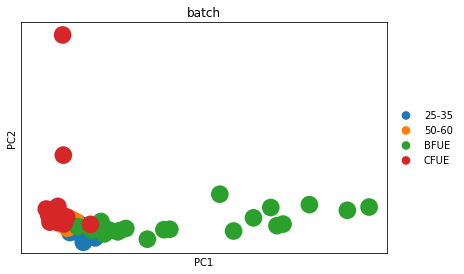

In [192]:
sc.tl.pca(untreated_cells)
sc.pl.pca(untreated_cells, color=["batch"])

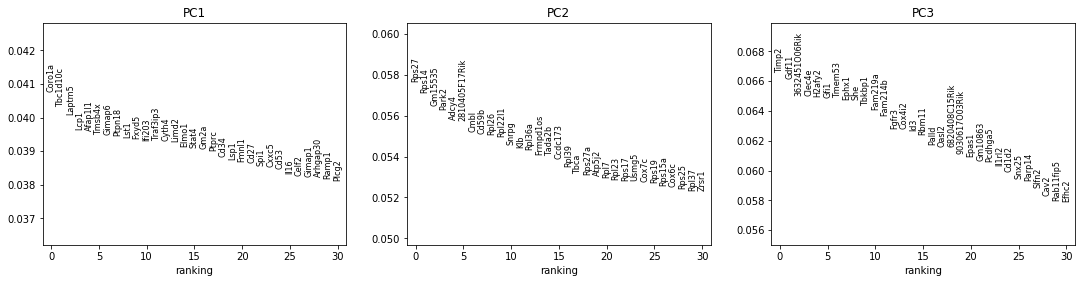

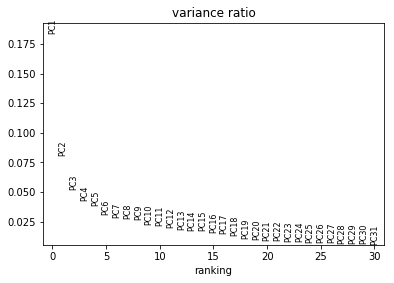

In [193]:
sc.pl.pca_loadings(untreated_cells)
sc.pl.pca_variance_ratio(untreated_cells)

In [166]:
#use the genes (and maybe same PCA loadings) from the better dataset to map the other ones
filt_adata = adata[:,untreated_cells.var_names]

Index(['mt-Cytb', 'mt-Nd5', 'mt-Nd4', 'mt-Nd2', 'mt-Nd1', 'mt-Rnr2', 'Zyx',
       'Ndn', 'B230219D22Rik', 'Mpo',
       ...
       'Gria3', 'Cav2', 'Rpl18a', 'Swi5', 'Fut7', 'Peg13', 'Tfrc', 'Fopnl',
       'Slirp', 'Dusp6'],
      dtype='object', length=1000)

## Treated Cells (w/ ctrl)

In [127]:
adata = sc.read_h5ad("cells_by_geneID.h5ad")
# adata = sc.read_h5ad("seurat_processed.h5ad")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [128]:
treated_cells = adata[adata.obs["batch"].isin(["BFUE-D1", "BFUE-D2", "BFUE-D3", "DEX-D1", "DEX-D2", "DEX-D3"])]
treated_cells

View of AnnData object with n_obs × n_vars = 576 × 49466 
    obs: 'batch'

In [129]:
#seurat as in scanpy, but setting n_top_genes at 1k
sc.pp.filter_cells(treated_cells, min_genes=200)
sc.pp.filter_genes(treated_cells, min_cells=3)

treated_cells.raw = sc.pp.log1p(treated_cells, copy=True)

sc.pp.normalize_per_cell(treated_cells, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(treated_cells.X, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000, log=False)
treated_cells._inplace_subset_var(filter_result.gene_subset)
sc.pp.log1p(treated_cells)
sc.pp.scale(treated_cells, max_value=10)

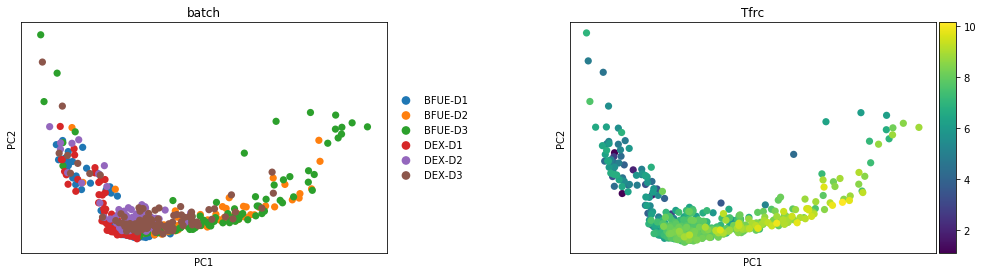

In [130]:
sc.tl.pca(treated_cells)
sc.pl.pca(treated_cells, color=["batch", "Tfrc"], use_raw = True)

Hojun said that some of the cells that look "early" might be multipotent progenitors.

In [142]:
sc.pp.neighbors(treated_cells, n_neighbors=15, n_pcs=50, method="gauss")
sc.tl.diffmap(treated_cells)

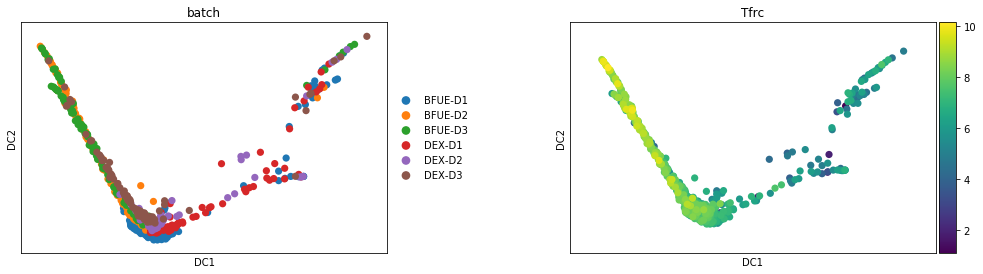

In [143]:
sc.pl.diffmap(treated_cells, color=["batch", "Tfrc"])

TODO: I want to see if I can plot this in the pca space of the batch corrected control data^: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [184]:
bdata

AnnData object with n_obs × n_vars = 276 × 1000 
    obs: 'batch', 'n_genes', 'n_counts', 'percent_mito', 'replicate', 'louvain'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'replicate_colors', 'batch_colors', 'neighbors', 'diffmap_evals', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'

In [185]:
treated_cells

AnnData object with n_obs × n_vars = 576 × 1000 
    obs: 'batch', 'n_genes', 'n_counts', 'louvain', 'dpt_pseudotime'
    var: 'n_cells'
    uns: 'pca', 'batch_colors', 'neighbors', 'diffmap_evals', 'draw_graph', 'louvain', 'louvain_colors', 'rank_genes_groups', 'iroot'
    obsm: 'X_pca', 'X_diffmap', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'

### Looking at it in a multidimensional, less collapsed space

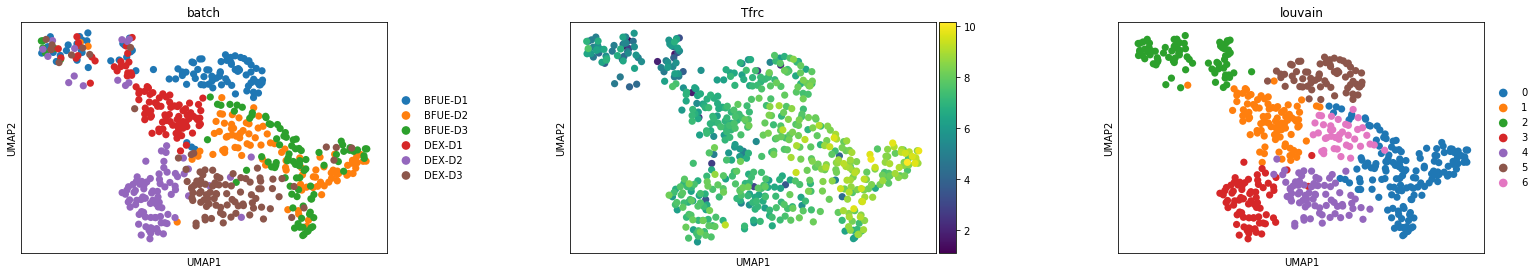

In [163]:
sc.tl.umap(treated_cells)
sc.tl.louvain(treated_cells, resolution=.8)
sc.pl.umap(treated_cells, color=["batch", "Tfrc", "louvain"])

Both force atlas and umap look like a fish. Is that a different developmental path...? Time to find out.

In [149]:
sc.tl.rank_genes_groups(treated_cells, "louvain")

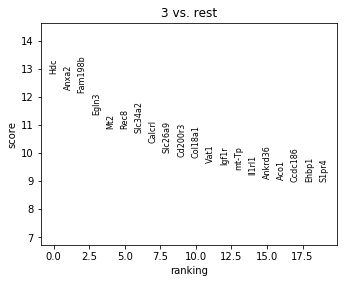

In [153]:
sc.pl.rank_genes_groups(treated_cells, "3")

In [162]:
treated_cells.uns["rank_genes_groups"]["names"]["3"]
treated_cells.uns["rank_genes_groups"]["scores"]["3"]

array([12.802625 , 12.248102 , 12.143415 , 11.343695 , 10.8512745,
       10.842967 , 10.719849 , 10.362122 , 10.008566 ,  9.864781 ,
        9.81636  ,  9.659974 ,  9.593802 ,  9.386265 ,  9.209246 ,
        9.06391  ,  9.028039 ,  8.976573 ,  8.975733 ,  8.957958 ,
        8.936526 ,  8.87076  ,  8.817033 ,  8.816698 ,  8.720473 ,
        8.552437 ,  8.431261 ,  8.381756 ,  8.333908 ,  8.291929 ,
        8.21187  ,  8.158119 ,  8.131199 ,  8.113454 ,  8.090368 ,
        8.088901 ,  8.082708 ,  8.062289 ,  8.030757 ,  7.9993486,
        7.9704432,  7.9426785,  7.9060535,  7.864324 ,  7.8547187,
        7.8536406,  7.8383913,  7.794806 ,  7.7172194,  7.715465 ,
        7.7068834,  7.705601 ,  7.6557016,  7.6263566,  7.616858 ,
        7.5883236,  7.538985 ,  7.5257573,  7.5077257,  7.4985714,
        7.496278 ,  7.440941 ,  7.433465 ,  7.4167814,  7.401328 ,
        7.3549376,  7.328522 ,  7.327234 ,  7.3129587,  7.2889237,
        7.288859 ,  7.2662187,  7.257236 ,  7.244271 ,  7.2393

### Pseudotime

In [168]:
treated_cells.uns['iroot'] = int(np.where(treated_cells.obs['batch'] == 'DEX-D1')[0][87])
sc.tl.dpt(treated_cells)

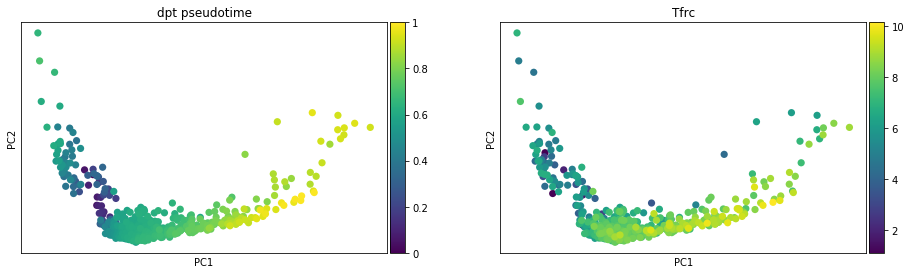

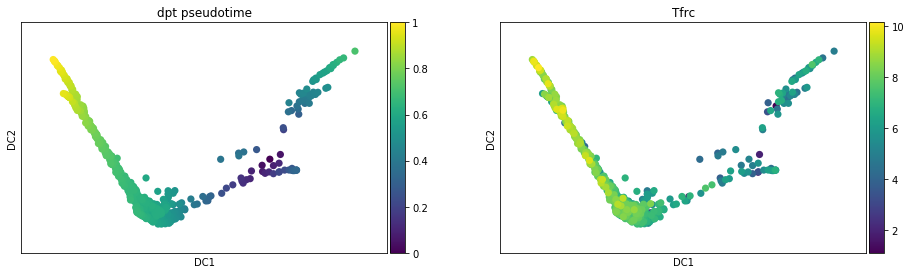

In [172]:
sc.pl.pca(treated_cells, color=["dpt_pseudotime", "Tfrc"])
sc.pl.diffmap(treated_cells, color=["dpt_pseudotime", "Tfrc"])

### Mapping onto the Tusi et. al dataset

In [173]:
tusi_data = sc.read_h5ad("Tusi/Tusi_processed.h5ad") #tbh I have no idea which of the Tusi samples these are... rip

In [174]:
tusi_data

AnnData object with n_obs × n_vars = 4691 × 613 
    obs: 'barcode', 'library_id', 'seq_run_id', 'pass_filter', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

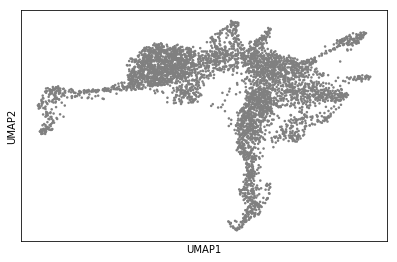

In [176]:
sc.pl.umap(tusi_data)

In [177]:
corrected = mnnpy.mnn_correct(tusi_data, treated_cells, batch_key="replicate", k=15, save_raw=True)

ValueError: Lengths must match to compare

In [179]:
len(tusi_data.var_names)

613

In [180]:
len(treated_cells.var_names)

1000

In [182]:
df = pd.read_csv("Tusi/GSM2985844_P1.raw_umifm_counts.csv.gz", sep=",")

,Sample,Library,Barcode_Seq,Total_Reads,Total_Counts,Pass_Total_Counts,Mito_Frac,Pass_Mito,Pass_All,0610007P14Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
0,P1,1,ACAATCTT-GCAGGGTA,29206,9850,1,0.1108,1,1,0,...,197,46,99,174,47,22,83,2,8,0
1,P1,1,TGGTTAAC-CACGGACT,11759,3839,1,0.1938,1,1,0,...,134,31,92,99,21,20,70,0,2,0
2,P1,1,ATTATTCG-TAGCTTAT,10040,3338,1,0.0905,1,1,0,...,63,19,24,42,10,10,23,0,2,1
3,P1,1,ACGACGAC-GCACCTCT,8943,2947,1,0.1995,1,1,0,...,105,25,52,80,16,15,48,0,6,0
4,P1,1,CTGAGCGT-ATGGGCAC,7935,2153,1,0.1686,1,1,0,...,41,21,46,58,16,10,35,1,4,0
5,P1,1,ATTACCTT-CTGGTGCA,6922,2346,1,0.2822,0,0,0,...,110,25,62,81,22,21,54,0,4,0
6,P1,1,CGTTGCCT-ATGACCGA,5753,1914,1,0.9922,0,0,0,...,295,82,191,252,81,64,178,4,7,2
7,P1,1,AGGCGTTT-GTGTCGGA,4745,1701,1,0.9912,0,0,0,...,259,70,186,207,55,39,201,0,8,0
8,P1,1,CTGAGCGT-GCAGTCGA,4031,1402,1,0.9879,0,0,0,...,230,62,165,179,62,42,154,0,5,0
9,P1,1,TGCCGGTA-GCAGTCGA,3476,1185,1,0.9890,0,0,0,...,177,76,125,156,41,28,140,0,5,0
